In this notebook we reduce the data for a single overlap scan (a lensv or lensh scan), load the reduced data, and fit it to a gaussian

# inputs

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import h5py
import sys
import os
import time
import scipy
import scipy.io as scio
from scipy.optimize import curve_fit


from LCLSDataToolsNew.GeneralTools import *
from LCLSDataToolsNew.filterTools import *
from LCLSDataToolsNew.diffSignalTools import *
from LCLSDataToolsNew.binningToolsErr import *
from LCLSDataToolsNew.anisotropyToolsAll import *
from LCLSDataToolsNew.SVDTools import *
from LCLSDataToolsNew.SetUpFns import *
from LCLSDataToolsNew.DiffBinFns import *
from LCLSDataToolsNew.ReduceFns import *
from LCLSDataToolsNew.IRFtools import *
from LCLSDataToolsNew.plottingTools import *

print('Import Complete!')

exper = 'xcslv9618'
### ffb ###
# smalldata_folder='/cds/data/drpsrcf/xcs/'+exper+'/scratch/hdf5/smalldata/'
### call ffb from psana ###
# smalldata_folder='/reg/data/drpsrcf/xcs/'+exper+'/scratch/hdf5/smalldata/'
### psana ###
smalldata_folder='/reg/d/psdm/xcs/'+exper+'/hdf5/smalldata/'


# outpath='/reg/d/psdm/xcs/'+exper+'/results/ReducedData/'
# outpath='/reg/d/psdm/xcs/'+exper+'/scratch/slr/'
outpath='/cds/home/s/slraj/code/ScatteringCode/'

# #make directories if needed 
if os.path.isdir(outpath+'/figures/')==False:
    os.makedirs(outpath+'/figures/')
if os.path.isdir(outpath+'/npy/')==False:
    os.makedirs(outpath+'/npy/')


Import Complete!


## set up varDict

In [2]:
varDict = {
        'ipm4'          : 'ipm4/sum',
        'ipm5'          : 'ipm5/sum',
        'xray_status'   : 'lightStatus/xray',
        'laser_status'  : 'lightStatus/laser',
        'ebeam_hv'      : 'ebeam/photon_energy',
        'scan_vec'      : 'scan/var0',
        'laser_diode'   : '/diodeGon/channels/',
    
        ## tt variables
        'ttCorr'        : 'tt/ttCorr',
        'ttAMPL'        : 'tt/AMPL',
        'ttFWHM'        : 'tt/FLTPOSFWHM',
        'ttFLTPOS'      : 'tt/FLTPOS',
        'encoder'       : 'enc/lasDelay',
        'lxt'           : 'epics/lxt' , 

        
        ## scattering variables
        'azav'      : 'epix10k2M/azav_azav',
        'qs'        : 'UserDataCfg/epix10k2M/azav__azav_q',
        'phis'      :  'UserDataCfg/epix10k2M/azav__azav_phiVec',
    


        }

## set up paramDict

In [3]:



paramDict= {
        'binSetup'  : 'unique', #bins are unique values of scan variable
        'binSet2'   : 300,
        'binMethod' : 'ave', 
        'qnorm'     : (2.5,3), 
        'qrange'    : (0.8,3.5),
        'show_filters'  : True, #show filter plots
        'useAzav_std'  : False, 
        'azav_percent_filter' : None, # if nonzero, use azav_std as filter
        'ipm'    : 5, # select ipm to use for I0
        'corr_filter' : False,
        'corr_threshold': .03 ,
        'ipm_filter' : (1000,None), #set limits for ipm intensity
        'Iscat_threshold'  : 100, #lower limit for Iscat
    
        'use_TT'   :  False,  
        'scan_var' : None,
        'x_var'   : None,
    
        't0_corr' : None,  #false or float offset for time zero
        'enforce_iso': False, #enforce isotropic off shots?
        'energy_corr' : False, # ebeam photon energy correction
        'NonLin_corr': None, #None, SVD, poly, or SVDbyBin
        
    
        'AdjSub'    : 50, #number of adjascent off shots to average and subtract, -1 subtracts all
        'aniso'  : False,
        'shift_n' :0,
        'xstat' : True,

        'BackSub': None,
        'earlytrange':(-0.5e-12,0e-12),

        'showSVD': False, #do svd
        'SVD_n': 4, # number of svd components
        'slice_plot': None, #how to slice up plots displayed at end
        'smooth':None, #smoothing before svd?

        'overwrite' : True, # overwrite files? 
        'save_mat'  : False,
        'save_h5' : False,

    }

# Run Reduction

loading  /reg/d/psdm/xcs/xcslv9618/hdf5/smalldata/xcslv9618_Run0244.h5
basename is  xcslv9618_Run0244
scan variable is  lens_h
finished loading h5
calculated Iscat
setupFilters - done!
12.885969400405884  seconds
saved reduction.png
using scan_vector for binning axis


/cds/home/s/slraj/code/ScatteringCode/LCLSDataToolsNew/DiffBinFns.py:106: RuntimeWarning: Mean of empty slice
  darkMean = np.nanmean(dark,0)


x-ray off subtraction done!
normalize data
(535,) (25259, 11, 535)


/cds/home/s/slraj/code/ScatteringCode/LCLSDataToolsNew/DiffBinFns.py:149: RuntimeWarning: Mean of empty slice
  cake=np.nanmean(divAny(cspad_azav[early_x,:,:],normal_factor[early_x,:]),0) #normalize by norm


normalize data done!
normalization applied
starting difference signal
Difference Signal Done!
22.642738819122314  seconds
Starting binning
bin by unique x axis value
dict_keys(['xcenter', 'xmean', 'xstd', 'bincount', 'binmean', 'binstd'])
binning - done!
23.8263099193573  seconds
saved output to /cds/home/s/slraj/code/ScatteringCode/npy/xcslv9618_Run0244_out.npy
16854/25259 events used
plotting azavs
logscan False
(21, 535)
(535,)
done
24.434163093566895  seconds


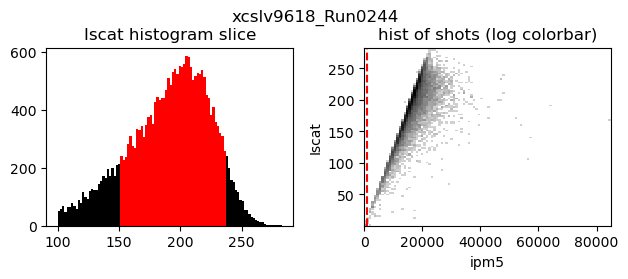

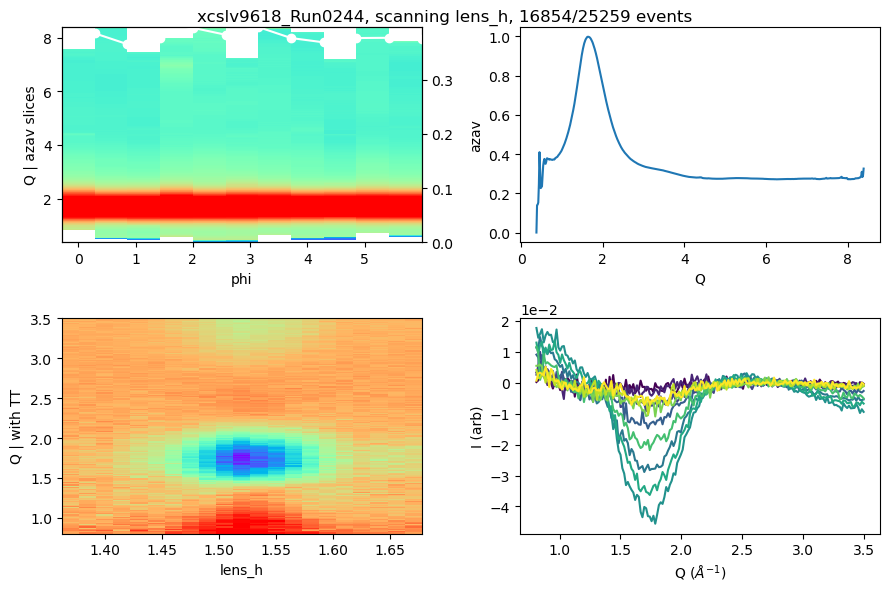

In [4]:
runs=[244]

ReduceData(smalldata_folder,exper,runs,outpath,paramDict,varDict)
    

# Load Data and Fit Gaussian

In [5]:
def gaus(x, a, b, c, d):
    return a * np.exp(-1*(x-b)**2/2/c**2) + d

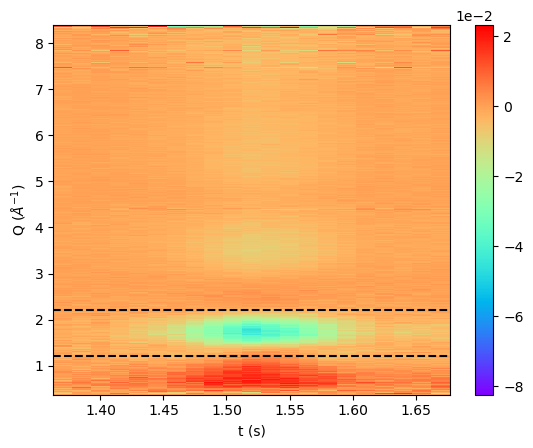

In [6]:
## fit q vs lens_h with gaussian and extract fwhm 
runnum=244
filepath=outpath+'/npy/'+exper+'_Run%04i_out.npy' %runnum

qrange=(1.2,2.2)            

data= np.load(filepath,allow_pickle= True).item()

qs=data['qs']
phis=data['phis'][0:-1]
scanvar=data['xcenter']
diff=data['diff_bin']

goodq = np.where((qs > qrange[0]) & (qs < qrange[1]))[0]
diff2d=np.nanmean(diff,1)#average over phis
plt.figure('scanvar2')
plot_2d(scanvar,qs,diff2d,fig='scanvar2')
plt.axhline(qrange[0],ls='--',color='k')
plt.axhline(qrange[1],ls='--',color='k')
# plt.clim(-5e-2,5e-2)
diff1d=np.nanmean(diff2d[:,goodq],1)

Text(0.5, 0.98, "('run=', 244, 'center=', 1.5260579143265247, 'fwhm=', 0.10083258042508851, 'qrange', (1.2, 2.2))")

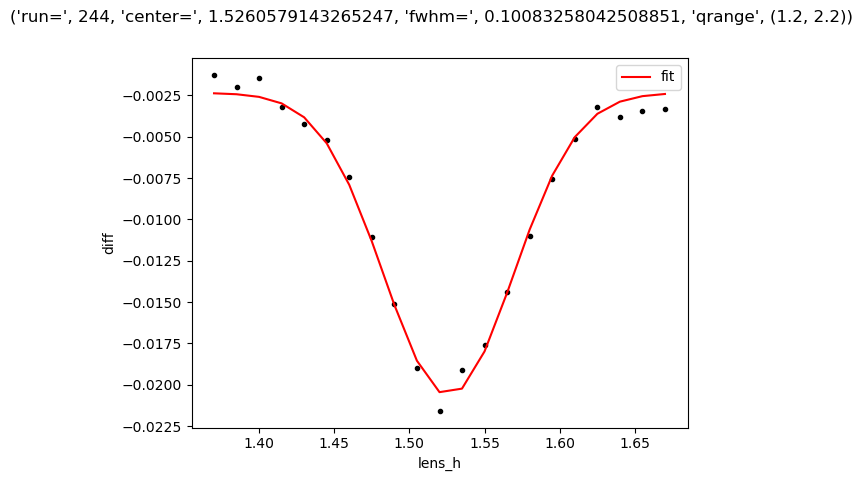

In [7]:

# lens_v=True
lens_v=False

if lens_v:
    p0=[.005,.05,.05,0.001] #lensv
    param, err =curve_fit(gaus,scanvar,diff1d,p0=p0)

    center=param[1]
    fwhm=param[2]*2.355
    
else:
    p0=[-.008,1.54,0.01,-0.001]
    param, err =curve_fit(gaus,scanvar,diff1d,p0=p0)

#     param, err =curve_fit(gaus,scanvar,diff1d)

center=param[1]
fwhm=param[2]*2.355

plt.figure('fit')
plt.plot(scanvar,diff1d,'k.')
plt.plot(scanvar,gaus(scanvar,*param),'r',label='fit')
if lens_v:
    plt.xlabel('lens_v')
else:
    plt.xlabel('lens_h')
plt.ylabel('diff')
plt.legend()
plt.suptitle(('run=',runnum,'center=',center,'fwhm=',fwhm,'qrange',qrange))